# **CE4145 - Natural Language Processing**
  > by John Michael Maciver (2203283)












**Generative AI was used to support completion of this assessment. The GenAI tool Gemini was used for the purpose of error corrections and spelling checks.**

## Section 1

**DataSet**

link: https://data.mendeley.com/datasets/jxy85cr3th/2

The dataset that I will be using is from “Steam Games Metadata and Player Reviews (2020–2024)” which as the name suggest Is a collection of datasets of Steam game metadata and player reviews, I will be using the dataset for the game “Cyberpunk 2077” “1091500” (name in source folder), I want to use what was said in the review to train a model to predict if the user recommended the game
or not.

In [1]:
import pandas as pd #pandas to view data in dataframes
import numpy as np #import numpy for arrays
import nltk #import the Natural Language Toolkit
import inflect # improt inflect for number converton

In [2]:
# Stores the file path for the data set
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP /Coursework/Cyberpunk_2077_review_steam_1091500.csv'

#loads the data set as a dataframe
fullDf = pd.read_csv(file_path)

#dispaly the full df
fullDf


,user,playtime,post_date,helpfulness,review,recommend,early_access_review
0,所多玛之兽,94.7,"October 31, 2021",12037,这游戏能让我捏人，但游戏里只有第一视角。我能捏🐮，但我的🐮🐮没有用武之地。我有超梦设备，但所...,Recommended,NaN
1,Airou,103.6,"September 26, 2023",6264,嘿Mano，听说了吗？狗镇刚来了个叫千寺狐的义体医生，又便宜手艺又好，老牛逼了😎,Recommended,NaN
2,healer,17.9,"November 1, 2022",5714,赞一次打一次亚当重锤！,Recommended,NaN
3,Godzilla320,242.6,"December 13, 2020",8775,或许这游戏改成“抢先体验”会更好,Recommended,NaN
4,正南灬齐北,60.0,"December 9, 2020",10296,测试场景为流浪者出身附近街道和街头小子出身酒吧门口，数据仅供参考基础胶片颗粒：不损失性能色差...,Recommended,NaN
...,...,...,...,...,...,...,...
26285,JayActer,432.1,"February 2, 2022",2,They fixed the game :OOOO,Recommended,NaN
26286,鸢一折纸,423.6,"February 1, 2022",2,不错的游戏,Recommended,NaN
26287,既含睇兮又宜笑，子慕予兮善窈窕,288.0,"February 1, 2022",2,我从未想过李德真能治好v我昏迷了整整两年我在昏迷中醒来，慌忙不迭的拨打着一个又一个朋友的电话...,Recommended,NaN
26288,_river_,16.0,"January 31, 2022",0,I am changing my review. Now that I'm waited s...,Recommended,NaN


The dataset consists of 26290 rows and 7 columns for the players username, game playtime, how many people found the review helpful, the review, if they recommend the game and did the play the game early

As we can see not all the reviews are in English, I will filter out all the reviews that don’t contain English and remove any that are empty or ascii art. As I will only be using the “review” and “recommend” columns I will be dropping the rest

In [3]:
!pip install langdetect #Install langdetect for language detection

from langdetect import detect

from langdetect.lang_detect_exception import LangDetectException

In [5]:
nltk.download('punkt_tab') #download the package in nltk which supports tokenization

from nltk.tokenize import word_tokenize

def is_english(text): # language detection based on the first x words

    num_words=10 # the number of words to check

    if not isinstance(text, str):
        return False

    text = text.strip()

    if not text:
        return False
    try:
        tokens = word_tokenize(text)
        if not tokens:
            return False

        # Take the first num_words for detection
        short_text = " ".join(tokens[:num_words])

        return detect(short_text) == 'en' # returns true if text is in english
    except LangDetectException:
        return False

# Apply the function to the 'review' column
engDf = fullDf[fullDf['review'].apply(is_english)].copy()

smallDf = engDf[["review","recommend"]].copy() #Creates a new dataset which only consists of the "review" and "recommend" columns
smallDf.reset_index(drop=True, inplace=True) #Resets the indexing

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
smallDf['review'] = smallDf['review'].apply(lambda x: x.encode("ascii", "ignore").decode("ascii")) # removes any non ascii Characters e.g. ♥, emoji

In [7]:
print(smallDf.head(10)) # print the head of new df

# prints the size of the full df and the new df
print(f"Original number of rows: {len(fullDf)}")
print(f"Number of rows with English reviews: {len(smallDf)}")

print("\n", smallDf["recommend"].value_counts())#prints the value counts of the classifier

                                              review    recommend
0   Rosa Walton - I Really Want to Stay At Your H...  Recommended
1  Been here since day 1, and I am someone who ca...  Recommended
2      Wake up, Samurai. We're out of Early Access.:  Recommended
3  something about this game tells me this "megac...  Recommended
4  I woke up, drank coffee, drove to the strip cl...  Recommended
5  Look mom I'm here... Very top of Arasaka Tower...  Recommended
6  I completed all the tasks, unlocked all the en...  Recommended
7  As we get older, playing games feels boring, e...  Recommended
8  I shied away from the game when it launched, a...  Recommended
9  Patch 1.5 fixed everything for me. The quests ...  Recommended
Original number of rows: 26290
Number of rows with English reviews: 8712

 recommend
Recommended        6511
Not Recommended    2201
Name: count, dtype: int64


In [8]:
engine = inflect.engine() # initialize the tool for converting numbers to text

#download the nltk packages
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords #import the package from the corpus
from nltk.stem.snowball import SnowballStemmer #import the stemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class pre_process(BaseEstimator, TransformerMixin): #pre processing class

  def __init__(self):
      return None

  def fit(self, x, y=None):
    return self

  def convert_number(self, text): # Number converting function

    if text.isdigit() :
      return engine.number_to_words(int(text))
    else:
       return text

  def transform(self, X, y=None):
    prep_text = []
    for x in X:
      token_text = word_tokenize(x) # Tokenize the text
      numless = [self.convert_number(token) for token in token_text] # convert the numbers to text
      normd_text = [token.lower() for token in numless] #normalize the text

      #to remove stopwords
      stwr = stopwords.words('english')
      swr_text = [token for token in normd_text if token not in stwr]

      stemmer = SnowballStemmer("english") #applies Stemming to the text
      prep_text += [[stemmer.stem(word) for word in swr_text]]

    prep_sentences = [" ".join(sentence) for sentence in prep_text]
    return prep_sentences #returns the preprocessed text



## Section 2

**Representation Learning**

For the Representation Learning I will be using Statistical-based methods such as “Bag of Words” (CountVectorizer) which will count how many times each token/word appears in the data and stores the result as a matrix. Then I will use “Term Frequency-Inverse Document Frequency” (TfidfTransformer) which will measure the tokens/word frequency then balances the values by reducing the weight of common tokens/words and increasing the weight of rare tokens/words.

In [10]:
#import the tools for Representaion learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

## Section 3
**Algorithms**


KNN – K-nearest neighbours work by taking in the new instance of data computes the data’s similarity to the to its historical data in this case the training data it then orders the data based on the similarity, then the algorithm votes on which label to give the new data based on its “ neighbours” and finally it outputs the label with the most votes      

MLP - multi-layer perceptron is a type of neural network which consists of at least three or more layers of neurons (input layer, output layer, and hidden layers). The input layer receives the data and passes it to the hidden layers. The hidden layers receive the data from the previous layer either the input layer or another hidden layer manipulates the data based on the weights and biases of the neuron which are learned over the training iterations before the data is passed to the next layer. The output layer produces the final output of the neural network.       


In [11]:
from sklearn.pipeline import Pipeline # Import the pipeline
from sklearn.neighbors import KNeighborsClassifier #import KNN
from sklearn.model_selection import StratifiedKFold #import StratifiedKFold
from sklearn.metrics import  classification_report #import classification_report

#split the df beween the data (x) and the Classifier (Y)
x = smallDf['review']
y = smallDf['recommend']

# initialize the pipeline for Knn
text_clf = Pipeline([
  ('prep', pre_process() ), #Preprocessor
  ('count', CountVectorizer()),#Vectorizer
  ('rep', TfidfTransformer()),# Representaion learning
  ('mod', KNeighborsClassifier(n_neighbors= 5)), # model
  ])

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  # Split between test and train sets
  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  text_clf.fit(x_train, y_train)# train Knn
  knn_predictions = text_clf.predict(x_test)# test Knn
  class_report = classification_report(y_test, knn_predictions) # create a report of the results

print(class_report)# print the results


                 precision    recall  f1-score   support

Not Recommended       0.77      0.02      0.04       440
    Recommended       0.75      1.00      0.86      1302

       accuracy                           0.75      1742
      macro avg       0.76      0.51      0.45      1742
   weighted avg       0.76      0.75      0.65      1742



In [12]:
from sklearn.neural_network import MLPClassifier #import MLP

# initialize the pipeline for MLP
text_clf_2 = Pipeline([
  ('prep', pre_process() ),
  ('count', CountVectorizer()),
  ('rep', TfidfTransformer()),
  ('mod', MLPClassifier(hidden_layer_sizes=(64,), activation="relu", batch_size=64, max_iter=10))
  ])

#split the df beween the data (x) and the Classifier (Y)
x = smallDf['review']
y = smallDf['recommend']


kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  # Split between test and train sets
  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  text_clf_2.fit(x_train, y_train) # train MLP
  mlp_predictions = text_clf_2.predict(x_test)#test MLP
  class_report = classification_report(y_test, mlp_predictions)# create a report of the results


print(class_report)# print the results


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

                 precision    recall  f1-score   support

Not Recommended       0.73      0.66      0.69       440
    Recommended       0.89      0.92      0.90      1302

       accuracy                           0.85      1742
      macro avg       0.81      0.79      0.80      1742
   weighted avg       0.85      0.85      0.85      1742




## Section 4

**Evaluation**

As we can see with the classification reports KNN starts out ok with an accuracy of 75% and precision of 77% (Not recommended) and 75% (Recommended) but as we look closer KNN is preforming poorly for the recall and f1 score when it comes to the “Not Recommended” class 0.02 recall and 0.04 f1 score. This tells us the almost all the 'Not Recommended' reviews are being misclassified as “Recommended” most likely caused by the data set being imbalanced making KNN biased to the “Recommended” class

MLP preformed significantly better than KNN in all categories with 85% accuracy and 0.64 recall and 0.69 f1 score for “Not Recommended” however there is still a noticeable number of reviews being misclassified.

Below is a confusion matrix to help visualize this.


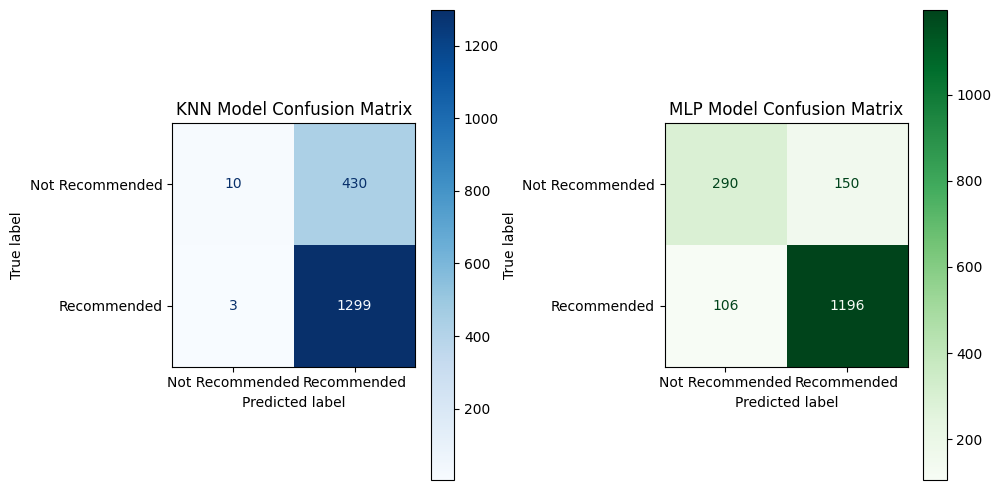

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Plot Confusion Matrix for KNN
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
cmd_knn = ConfusionMatrixDisplay.from_predictions(y_test, knn_predictions, cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
cmd_knn.ax_.set_title('KNN Model Confusion Matrix')

# Plot Confusion Matrix for MLP
plt.subplot(1, 2, 2)
cmd_mlp = ConfusionMatrixDisplay.from_predictions(y_test, mlp_predictions, cmap=plt.cm.Greens, values_format='d', ax=plt.gca())
cmd_mlp.ax_.set_title('MLP Model Confusion Matrix')

plt.tight_layout()
plt.show()

KNN has classified almost all the “not recommended” reviews wrong, whereas MLP has performed better in classifying “not recommended”. However, it looks like MLP is worse at classifying the “recommended” reviews. I’m not too worried by this, as it shows that MLP isn’t defaulting to one classifier.